In [1]:
!wget http://snap.stanford.edu/data/cit-HepPh.txt.gz -O CitationGraph.txt.gz
!gunzip CitationGraph.txt.gz

--2024-11-16 18:41:10--  http://snap.stanford.edu/data/cit-HepPh.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1664504 (1.6M) [application/x-gzip]
Saving to: ‘CitationGraph.txt.gz’

CitationGraph.txt.g 100%[===================>]   1.59M  1.26MB/s    in 1.3s    

2024-11-16 18:41:12 (1.26 MB/s) - ‘CitationGraph.txt.gz’ saved [1664504/1664504]



In [2]:
!wget http://snap.stanford.edu/data/cit-HepPh-dates.txt.gz -O CitationDates.txt.gz
!gunzip CitationDates.txt.gz

--2024-11-16 18:41:12--  http://snap.stanford.edu/data/cit-HepPh-dates.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96569 (94K) [application/x-gzip]
Saving to: ‘CitationDates.txt.gz’

CitationDates.txt.g 100%[===================>]  94.31K   339KB/s    in 0.3s    

2024-11-16 18:41:12 (339 KB/s) - ‘CitationDates.txt.gz’ saved [96569/96569]



In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random

In [4]:
# https://www.researchgate.net/publication/362459677_Community_detection_methods_for_directed_graphs/fulltext/64f6965a827074313ffd97b6/Community-detection-methods-for-directed-graphs.pdf

In [5]:
# https://arxiv.org/abs/1308.0971

In [ ]:
# https://www.pnas.org/doi/epdf/10.1073/pnas.0706851105

In [6]:
# Get basic info about the nodes of the graph

graph = nx.DiGraph()
reverse_graph = nx.DiGraph()


max_id = 0
min_id = 1e9

nodes = set()

edge_list = []

with open("CitationGraph.txt", "r") as f:

    lines = f.readlines()
    lines = [line.strip("\n") for line in lines[4:]]

    for line in lines:
        a, b = line.split()
        a = int(a)
        b = int(b)

        max_id = max(max_id, a, b)
        min_id = min(min_id, a, b)

        nodes.add(a)
        nodes.add(b)

        edge_list.append((a, b))

nodes = list(nodes)
nodes.sort()
graph.add_nodes_from(nodes)
reverse_graph.add_nodes_from(nodes)
num_nodes = len(nodes)

for pair in edge_list:
    # if pair[0] == pair[1]:
    #     continue
    graph.add_edge(pair[0], pair[1])
    reverse_graph.add_edge(pair[1], pair[0])


num_edges = graph.number_of_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

max_id

Number of nodes: 34546
Number of edges: 421578


9912553

In [7]:
date_node = []
node_dates = {}

with open("CitationDates.txt", "r") as f:
    lines = f.readlines()
    lines = [line.strip("\n") for line in lines[1:]]

    for line in lines:
        a, b = line.split()
        if(len(a) > 7):
             a = a[2:]
        a = int(a.lstrip('0'))
        if not graph.has_node(a):
            if str(a)[:2] == "11":
                a = int(str(a)[2:])
            if not graph.has_node(a):
                continue
        # date_node.append((b, a))
        if(node_dates.get(a) == None):
            node_dates[a] = b
        else:
            node_dates[a] = min(node_dates[a], b)

for node in node_dates:
    date_node.append((node_dates[node], node))

# for node in graph.nodes():              # If the date of a particular paper is not in the file, we set the date to be something greater than the latest paper
#     if node_dates.get(node) == None:
#         node_dates[node] = "2002-04-01"
#         date_node.append((node_dates[node], node))

date_node.sort()
print(len(date_node))
cnt = 0


30561


In [8]:
def lower_bound(date):
    l = 0
    r = len(date_node)

    while l != r:
        mid = int((l+r)/2)
        if(date_node[mid][0] >= date):
            r = mid
        else:
            l = mid + 1
    return l


In [9]:
time_graph = nx.DiGraph()
time_reverse_graph = nx.DiGraph()

def add_edges(start_date, end_date):
    start_idx = lower_bound(start_date)

    for i in range(start_idx, len(date_node)):
        if(date_node[i][0] > end_date):
            break
        # print(start_date, end_date, )
        node = date_node[i][1]
        time_graph.add_node(node)
        time_reverse_graph.add_node(node)
        if node not in graph.nodes():
            continue
        for e in graph.neighbors(node):
            if time_graph.has_node(e):
                time_graph.add_edge(node, e)
                time_reverse_graph.add_edge(e, node)

        for e in reverse_graph.neighbors(node):
            if time_graph.has_node(e):
                time_graph.add_edge(e, node)
                time_reverse_graph.add_edge(node, e)

def add_bidirectional_edges(start_date, end_date):
    start_idx = lower_bound(start_date)

    for i in range(start_idx, len(date_node)):
        if(date_node[i][0] > end_date):
            break
        # print(start_date, end_date, )
        node = date_node[i][1]
        time_graph.add_node(node)
        time_reverse_graph.add_node(node)
        for e in graph.neighbors(node):
            if time_graph.has_node(e):
                time_graph.add_edge(node, e)

        for e in reverse_graph.neighbors(node):
            if time_graph.has_node(e):
                time_graph.add_edge(e, node)


In [ ]:
og_graph = graph.copy()
global_community = {node:{node} for node in graph.nodes()}
edges = {(a, b): 1 for a, b in graph.edges()}

cnt = 0
while True:
    # if cnt > 300:
    #     break
    cnt +=1
    community = {node:node for node in graph.nodes()}
    communities = {node:{node} for node in graph.nodes()}
    Q = 0
    m = sum(edges.values())

    indeg = {node:0 for node in graph.nodes()}
    outdeg = {node:0 for node in graph.nodes()}

    if m == 0:
        break

    for p in edges:

        indeg[p[0]] += edges[p]
        outdeg[p[1]] += edges[p]

    for node in graph.nodes():
        if((node, node) in edges):
            Q += edges[(node, node)]
        Q -= indeg[node] * outdeg[node] / m
    Q /= m

    print("Iteration:", cnt, Q)

    prev_Q = Q
    cnt2 = 0
    for node in graph.nodes():
        cnt2 += 1
        max_del = 0
        best_com = 0
        proc = set()
        for node2 in set(graph.successors(node)) | set(graph.predecessors(node)):
            if community[node] == community[node2] or community[node2] in proc:
                continue
            proc.add(community[node2])
            delta = 0
            for x in communities[community[node2]]:
                if((node, x) in edges):
                    delta += edges[(node, x)]
                if((x, node) in edges):
                    delta += edges[(x, node)]
                delta -= indeg[x] * outdeg[node] / m
                delta -= indeg[node] * outdeg[x] / m
            for x in communities[community[node]]:
                if((node, x) in edges):
                    delta -= edges[(node, x)]
                if((x, node) in edges):
                    delta -= edges[(x, node)]
                if x != node:
                    delta += indeg[x] * outdeg[node] / m
                    delta += indeg[node] * outdeg[x] / m
            delta /= m
            if delta > max_del:
                max_del = delta
                best_com = community[node2]
        if cnt2 % 1000 == 0:
            print(cnt2, node, max_del)
        if max_del > 0:
            communities[community[node]].remove(node)
            if len(communities[community[node]]) == 0:
                del communities[community[node]]
            communities[best_com].add(node)
            community[node] = best_com
            Q += max_del

    if Q == prev_Q:
        break

    new_graph = nx.DiGraph()
    edges = {}

    for com in communities:
        new_graph.add_node(com)
    for com in communities:
        for node in communities[com]:
            for node2 in graph.successors(node):
                # if community[node] != community[node2]:
                if new_graph.has_edge(community[node], community[node2]):
                    edges[(community[node], community[node2])] += 1
                else:
                    edges[(community[node], community[node2])] = 1
                    new_graph.add_edge(community[node], community[node2])
    global_comm2 = {}
    for com in communities:
        curr = set()
        for node in communities[com]:
            curr = curr.union(global_community[node])
        global_comm2[com] = curr
    global_community = global_comm2
    graph = new_graph

graph = og_graph.copy()

# global_community


Iteration: 1 6.751202578776872e-05
1000 4053 2.371320085116629e-06
2000 7126 2.3712300599146793e-06
3000 10087 9.208109623387552e-06
4000 12357 4.741886209166926e-06
5000 103299 4.7253103188578655e-06
6000 106300 0
7000 110067 4.735100559569939e-06
8000 112219 2.371201927039069e-06
9000 204018 2.3709881171844383e-06
10000 207020 4.487486241606212e-05
11000 210015 3.782912438406503e-05
12000 212126 1.2080633767211079e-05
13000 9207258 2.371939008380036e-06
14000 9306289 9.461412408799498e-06
15000 9401284 2.2506300487536632e-11
16000 9406423 3.95361428774168e-06
17000 9411395 4.732298525159242e-06
18000 9504283 4.7434222641752e-06
19000 9508293 3.693331173233531e-05
20000 9512360 6.898209232301376e-06
21000 9605215 4.743427890750322e-06
22000 9608402 4.743456023625931e-06
23000 9612201 2.371837730027842e-06
24000 9704202 4.683319188723267e-06
25000 9707336 2.1177641038241976e-06
26000 9710400 4.7005815211972025e-06
27000 9801392 4.743731725806903e-06
28000 9805337 3.7653440202459425e-05

In [ ]:
len(global_community)

503

In [11]:
def modularity(graph, communities):
    community = {}
    for com in communities:
        for node in communities[com]:
            community[node] = com
    m = graph.number_of_edges()
    Q = 0
    indeg = {node: graph.in_degree(node) for node in graph.nodes()}
    outdeg = {node: graph.out_degree(node) for node in graph.nodes()}

    for node in graph.nodes():
        for node2 in set(graph.successors(node)):
            if community[node] == community[node2]:
                Q += 1

    for com in communities:
        tot_out = sum(outdeg[node] for node in communities[com])
        tot_in = sum(indeg[node] for node in communities[com])

        Q -= indeg[node] * tot_out / m

    return Q/m

In [ ]:
modularity(graph, global_community)

0.8241440492625327

In [ ]:
time_graph = nx.DiGraph()

published_year = tuple(str(year) for year in range(1992, 2003))
modularity_scores = [0 for _ in range(11)]
com_sizes = [[] for _ in range(11)]
max_size = [0 for _ in range(11)]
num_coms = [0 for _ in range(11)]

for i in range(1992, 2003):
    print("************************************")
    print(i)
    add_edges(str(i)+'-01-01', str(i)+'-12-31')
    og_graph = time_graph.copy()
    global_community = {node:{node} for node in time_graph.nodes()}
    edges = {(a, b): 1 for a, b in time_graph.edges()}

    cnt = 0
    while True:
        # if cnt > 300:
        #     break
        cnt +=1
        community = {node:node for node in time_graph.nodes()}
        communities = {node:{node} for node in time_graph.nodes()}
        Q = 0
        m = sum(edges.values())

        indeg = {node:0 for node in time_graph.nodes()}
        outdeg = {node:0 for node in time_graph.nodes()}

        if m == 0:
            break

        for p in edges:

            indeg[p[0]] += edges[p]
            outdeg[p[1]] += edges[p]

        for node in time_graph.nodes():
            if((node, node) in edges):
                Q += edges[(node, node)]
            Q -= indeg[node] * outdeg[node] / m
        Q /= m

        print("Iteration:", cnt, Q)

        prev_Q = Q
        cnt2 = 0
        for node in time_graph.nodes():
            cnt2 += 1
            max_del = 0
            best_com = 0
            proc = set()
            for node2 in set(time_graph.successors(node)) | set(time_graph.predecessors(node)):
                if community[node] == community[node2] or community[node2] in proc:
                    continue
                proc.add(community[node2])
                delta = 0
                for x in communities[community[node2]]:
                    if((node, x) in edges):
                        delta += edges[(node, x)]
                    if((x, node) in edges):
                        delta += edges[(x, node)]
                    delta -= indeg[x] * outdeg[node] / m
                    delta -= indeg[node] * outdeg[x] / m
                for x in communities[community[node]]:
                    if((node, x) in edges):
                        delta -= edges[(node, x)]
                    if((x, node) in edges):
                        delta -= edges[(x, node)]
                    if x != node:
                        delta += indeg[x] * outdeg[node] / m
                        delta += indeg[node] * outdeg[x] / m
                delta /= m
                if delta > max_del:
                    max_del = delta
                    best_com = community[node2]
            if cnt2 % 1000 == 0:
                print(cnt2, node, max_del)
            if max_del > 0:
                communities[community[node]].remove(node)
                if len(communities[community[node]]) == 0:
                    del communities[community[node]]
                communities[best_com].add(node)
                community[node] = best_com
                Q += max_del

        if Q == prev_Q:
            break

        new_graph = nx.DiGraph()
        edges = {}

        for com in communities:
            new_graph.add_node(com)
        for com in communities:
            for node in communities[com]:
                for node2 in time_graph.successors(node):
                    # if community[node] != community[node2]:
                    if new_graph.has_edge(community[node], community[node2]):
                        edges[(community[node], community[node2])] += 1
                    else:
                        edges[(community[node], community[node2])] = 1
                        new_graph.add_edge(community[node], community[node2])
        global_comm2 = {}
        for com in communities:
            curr = set()
            for node in communities[com]:
                curr = curr.union(global_community[node])
            global_comm2[com] = curr
        global_community = global_comm2
        time_graph = new_graph

    time_graph = og_graph.copy()

    com_sizes[i-1992] = [len(com) for com in global_community.values()]
    com_sizes[i-1992].sort(reverse=True)
    max_size[i-1992] = com_sizes[i-1992][0]
    num_coms[i-1992] = len(global_community)
    modularity_scores[i-1992] = modularity(time_graph, global_community)


************************************
1992
Iteration: 1 -0.0008223684210526315
Iteration: 2 0.723424515235457
************************************
1993
Iteration: 1 0.001152600327870293
1000 9305214 0
2000 9312226 0
Iteration: 2 0.37914580851964647
1000 9311293 0
Iteration: 3 0.32531672240292214
1000 9312227 0
Iteration: 4 0.3509749413942054
1000 9312283 0
Iteration: 5 0.3570110722093671
1000 9312319 0
Iteration: 6 0.3667171332283355
1000 9312360 0
Iteration: 7 0.380897880703316
Iteration: 8 0.37897380248781537
Iteration: 9 0.36645310527954794
Iteration: 10 0.3819577237525983
Iteration: 11 0.38264998180342014
Iteration: 12 0.38987617848301753
Iteration: 13 0.3867524482696216
************************************
1994
Iteration: 1 0.00035917061014078644
1000 9305214 0
2000 9312226 8.786573843314204e-05
3000 9406216 0
4000 9410400 0.0001755770148140152
Iteration: 2 0.26740365454589954
1000 9404340 0
2000 9412362 0
Iteration: 3 0.3060525458153102
1000 9407265 0.00012759286037216728
Iteratio

[Text(0, 0, '0.743'),
 Text(0, 0, '0.713'),
 Text(0, 0, '0.843'),
 Text(0, 0, '0.850'),
 Text(0, 0, '0.810'),
 Text(0, 0, '0.812'),
 Text(0, 0, '0.837'),
 Text(0, 0, '0.817'),
 Text(0, 0, '0.808'),
 Text(0, 0, '0.805'),
 Text(0, 0, '0.832')]

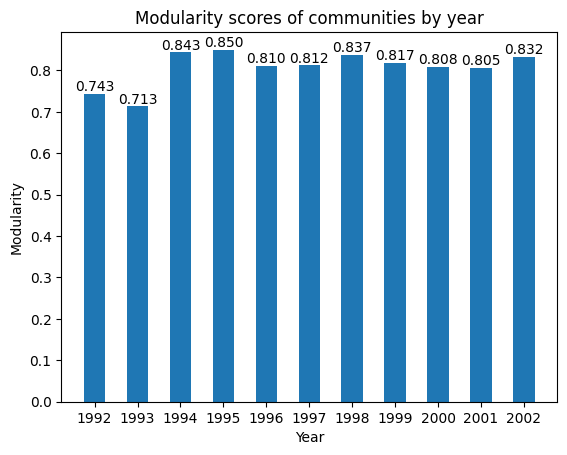

In [ ]:
fig, ax = plt.subplots()
bar_container = ax.bar(published_year, modularity_scores, width=0.5)
ax.set(xlabel='Year', ylabel='Modularity', title='Modularity scores of communities by year')
ax.bar_label(bar_container, fmt='{:,.3f}')

[Text(0, 0, '470'),
 Text(0, 0, '960'),
 Text(0, 0, '1065'),
 Text(0, 0, '933'),
 Text(0, 0, '810'),
 Text(0, 0, '705'),
 Text(0, 0, '645'),
 Text(0, 0, '604'),
 Text(0, 0, '592'),
 Text(0, 0, '551'),
 Text(0, 0, '543')]

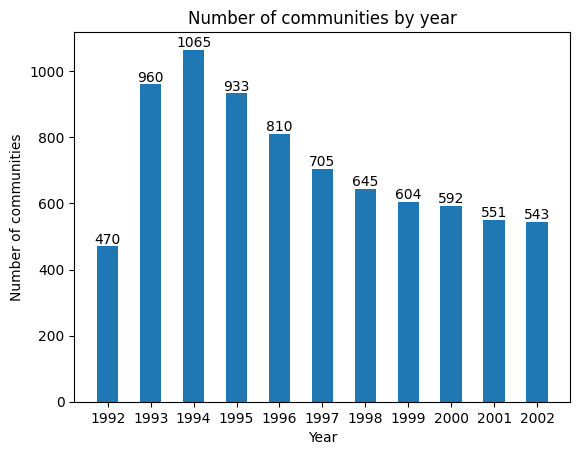

In [ ]:
fig, ax = plt.subplots()
bar_container = ax.bar(published_year, num_coms, width=0.5)
ax.set(xlabel='Year', ylabel='Number of communities', title='Number of communities by year')
ax.bar_label(bar_container)

[Text(0, 0, '1.047'),
 Text(0, 0, '1.387'),
 Text(0, 0, '1.602'),
 Text(0, 0, '1.747'),
 Text(0, 0, '1.947'),
 Text(0, 0, '2.149'),
 Text(0, 0, '2.271'),
 Text(0, 0, '2.426'),
 Text(0, 0, '3.005'),
 Text(0, 0, '3.936'),
 Text(0, 0, '4.525')]

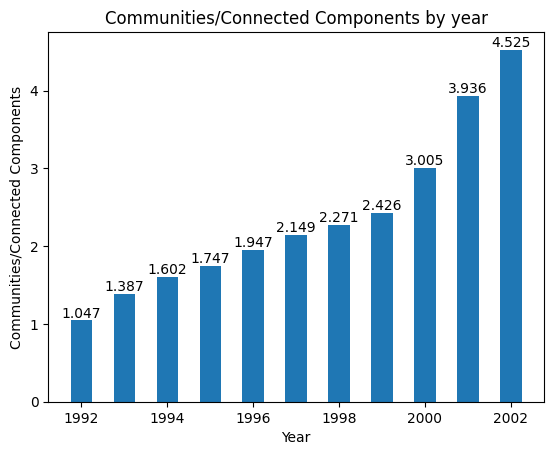

In [ ]:
time_graph = nx.DiGraph()

y_val = [0 for _ in range(11)]
x_val = [i + 1992 for i in range(11)]

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')
    y_val[i - 1992] = num_coms[i-1992]/nx.number_weakly_connected_components(time_graph)

fig, axs = plt.subplots()
# plt.subplots_adjust(wspace=0.5)
ax = axs
bar_container = ax.bar(x_val, y_val, width=0.5)
ax.set(xlabel='Year', ylabel='Communities/Connected Components', title='Communities/Connected Components by year')
ax.bar_label(bar_container, fmt='{:,.3f}')

[Text(0, 0, '6'),
 Text(0, 0, '286'),
 Text(0, 0, '1281'),
 Text(0, 0, '1743'),
 Text(0, 0, '2136'),
 Text(0, 0, '4268'),
 Text(0, 0, '5916'),
 Text(0, 0, '5325'),
 Text(0, 0, '6770'),
 Text(0, 0, '9566'),
 Text(0, 0, '9446')]

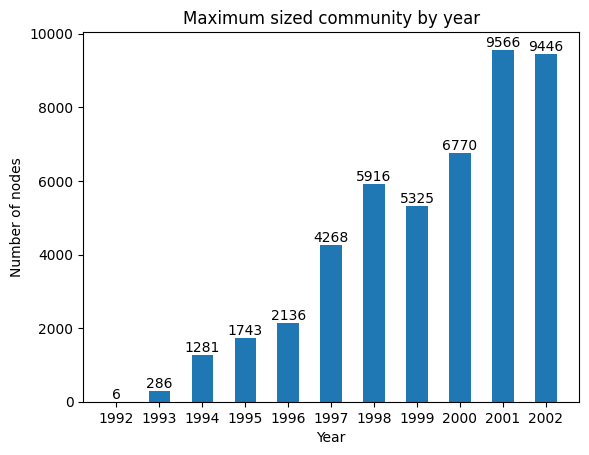

In [ ]:
fig, ax = plt.subplots()
bar_container = ax.bar(published_year, max_size, width=0.5)
ax.set(xlabel='Year', ylabel='Number of nodes', title='Maximum sized community by year')
ax.bar_label(bar_container)

[Text(0, 0, '1.2383'),
 Text(0, 0, '2.20521'),
 Text(0, 0, '4.15117'),
 Text(0, 0, '7.7985'),
 Text(0, 0, '12.9395'),
 Text(0, 0, '19.8766'),
 Text(0, 0, '27.4977'),
 Text(0, 0, '35.9917'),
 Text(0, 0, '43.7382'),
 Text(0, 0, '54.225'),
 Text(0, 0, '73.0359')]

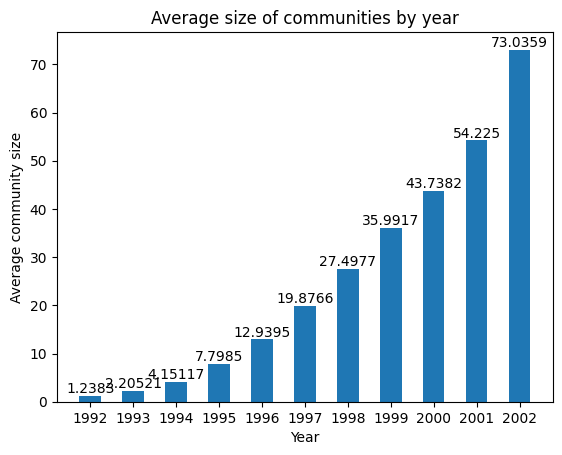

In [ ]:
avg_coms = [0 for _ in range(11)]
for i in range(11):
    avg_coms[i] = sum(com_sizes[i])/len(com_sizes[i])
fig, ax = plt.subplots()
bar_container = ax.bar(published_year, avg_coms, width=0.5)
ax.set(xlabel='Year', ylabel='Average community size', title='Average size of communities by year')
ax.bar_label(bar_container)

In [ ]:
com_size = [len(com) for com in global_community.values()]
com_size.sort(reverse=True)
com_size[:10]

[11058, 5396, 4668, 2950, 2917, 2905, 2039, 1375, 13, 9]

In [ ]:
import json

with open("node_id.json", "r") as f:
    node_to_id = json.load(f)

len(node_to_id)

19780

In [ ]:
L = [0 for _ in range(len(node_to_id))]
for com in global_community:
    for node in global_community[com]:
        if str(node) in node_to_id:
            L[node_to_id[str(node)]] = com
            # print(node_to_id[str(node)], com)

import io

out_m = io.open("colours.tsv", "w", encoding="utf-8")

for i in range(len(L)):
    out_m.write(str(L[i]) + "\n")
out_m.close()

In [8]:
!pip install infomap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.8/264.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for infomap: filename=infomap-2.8.0-cp310-cp310-linux_x86_64.whl size=7695875 sha256=ead37b4d6eb40ad302ff8239c06e46eb8cf9ed408a5bf7f31aab78807b7a4628
  Stored in directory: /root/.cache/pip/wheels/b5/0c/9b/9816a0207b931219a0c5b2edc14d84099ddd57f7097f926b16
Successfully built infomap


In [9]:
# https://mapequation.github.io/infomap/python/
from infomap import Infomap

# Command line flags can be added as a string to Infomap
im = Infomap("--two-level --directed")

im.add_networkx_graph(graph)

im.run()

In [12]:
communities = {}
for node in im.nodes:
    if node.module_id not in communities:
        communities[node.module_id] = set()
    communities[node.module_id].add(node.node_id)

modularity(graph, communities)

0.5824473762862389

In [14]:
time_graph = nx.DiGraph()

published_year = tuple(str(year) for year in range(1992, 2003))
modularity_scores = [0 for _ in range(11)]
com_sizes = [[] for _ in range(11)]
max_size = [0 for _ in range(11)]
num_coms = [0 for _ in range(11)]

for i in range(1992, 2003):
    print("************************************")
    print(i)
    add_edges(str(i)+'-01-01', str(i)+'-12-31')

    im = Infomap("--two-level --directed")

    im.add_networkx_graph(time_graph)

    im.run()

    global_community = {}
    for node in im.nodes:
        if node.module_id not in global_community:
            global_community[node.module_id] = set()
        global_community[node.module_id].add(node.node_id)

    com_sizes[i-1992] = [len(com) for com in global_community.values()]
    com_sizes[i-1992].sort(reverse=True)
    max_size[i-1992] = com_sizes[i-1992][0]
    num_coms[i-1992] = len(global_community)
    modularity_scores[i-1992] = modularity(time_graph, global_community)


************************************
1992
************************************
1993
************************************
1994
************************************
1995
************************************
1996
************************************
1997
************************************
1998
************************************
1999
************************************
2000
************************************
2001
************************************
2002


[Text(0, 0, '0.849'),
 Text(0, 0, '0.722'),
 Text(0, 0, '0.654'),
 Text(0, 0, '0.583'),
 Text(0, 0, '0.587'),
 Text(0, 0, '0.582'),
 Text(0, 0, '0.574'),
 Text(0, 0, '0.584'),
 Text(0, 0, '0.590'),
 Text(0, 0, '0.591'),
 Text(0, 0, '0.591')]

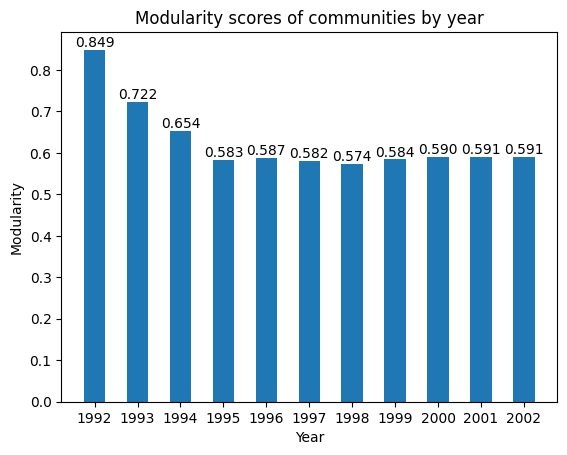

In [15]:
fig, ax = plt.subplots()
bar_container = ax.bar(published_year, modularity_scores, width=0.5)
ax.set(xlabel='Year', ylabel='Modularity', title='Modularity scores of communities by year')
ax.bar_label(bar_container, fmt='{:,.3f}')

[Text(0, 0, '461'),
 Text(0, 0, '831'),
 Text(0, 0, '933'),
 Text(0, 0, '920'),
 Text(0, 0, '873'),
 Text(0, 0, '830'),
 Text(0, 0, '854'),
 Text(0, 0, '874'),
 Text(0, 0, '851'),
 Text(0, 0, '825'),
 Text(0, 0, '818')]

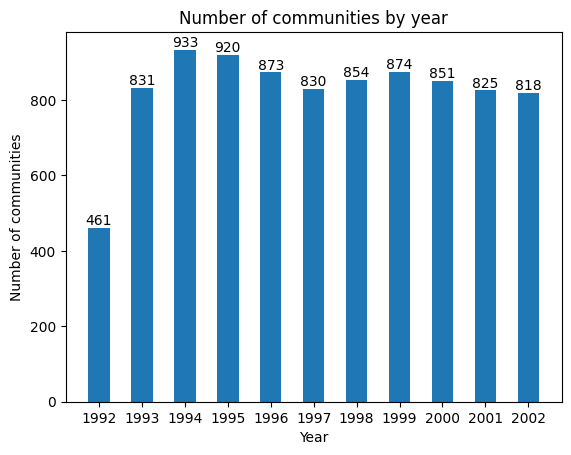

In [16]:
fig, ax = plt.subplots()
bar_container = ax.bar(published_year, num_coms, width=0.5)
ax.set(xlabel='Year', ylabel='Number of communities', title='Number of communities by year')
ax.bar_label(bar_container)

[Text(0, 0, '1.027'),
 Text(0, 0, '1.201'),
 Text(0, 0, '1.403'),
 Text(0, 0, '1.723'),
 Text(0, 0, '2.099'),
 Text(0, 0, '2.530'),
 Text(0, 0, '3.007'),
 Text(0, 0, '3.510'),
 Text(0, 0, '4.320'),
 Text(0, 0, '5.893'),
 Text(0, 0, '6.817')]

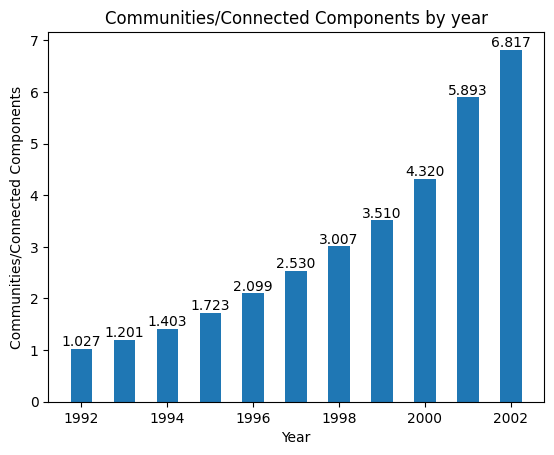

In [17]:
time_graph = nx.DiGraph()

y_val = [0 for _ in range(11)]
x_val = [i + 1992 for i in range(11)]

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')
    y_val[i - 1992] = num_coms[i-1992]/nx.number_weakly_connected_components(time_graph)

fig, axs = plt.subplots()
# plt.subplots_adjust(wspace=0.5)
ax = axs
bar_container = ax.bar(x_val, y_val, width=0.5)
ax.set(xlabel='Year', ylabel='Communities/Connected Components', title='Communities/Connected Components by year')
ax.bar_label(bar_container, fmt='{:,.3f}')

[Text(0, 0, '11'),
 Text(0, 0, '82'),
 Text(0, 0, '161'),
 Text(0, 0, '234'),
 Text(0, 0, '347'),
 Text(0, 0, '407'),
 Text(0, 0, '520'),
 Text(0, 0, '818'),
 Text(0, 0, '1041'),
 Text(0, 0, '1364'),
 Text(0, 0, '1432')]

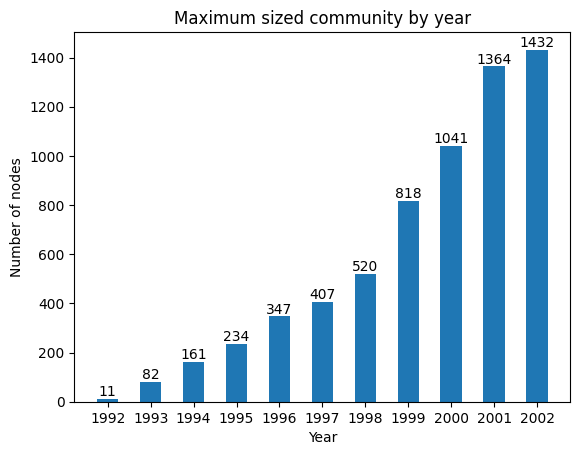

In [18]:
fig, ax = plt.subplots()
bar_container = ax.bar(published_year, max_size, width=0.5)
ax.set(xlabel='Year', ylabel='Number of nodes', title='Maximum sized community by year')
ax.bar_label(bar_container)

[Text(0, 0, '1.26247'),
 Text(0, 0, '2.54753'),
 Text(0, 0, '4.73848'),
 Text(0, 0, '7.9087'),
 Text(0, 0, '12.0057'),
 Text(0, 0, '16.8831'),
 Text(0, 0, '20.7681'),
 Text(0, 0, '24.873'),
 Text(0, 0, '30.4266'),
 Text(0, 0, '36.2158'),
 Text(0, 0, '37.3606')]

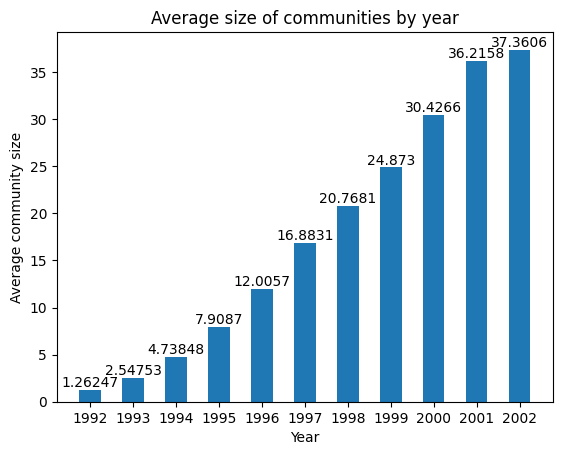

In [19]:
avg_coms = [0 for _ in range(11)]
for i in range(11):
    avg_coms[i] = sum(com_sizes[i])/len(com_sizes[i])
fig, ax = plt.subplots()
bar_container = ax.bar(published_year, avg_coms, width=0.5)
ax.set(xlabel='Year', ylabel='Average community size', title='Average size of communities by year')
ax.bar_label(bar_container)

In [ ]:
L = [0 for _ in range(len(node_to_id))]
for com in communities:
    for node in communities[com]:
        if str(node) in node_to_id:
            L[node_to_id[str(node)]] = com
            # print(node_to_id[str(node)], com)

import io

out_m = io.open("colours_2.tsv", "w", encoding="utf-8")

for i in range(len(L)):
    out_m.write(str(L[i]) + "\n")
out_m.close()

In [20]:
model = tf.keras.models.load_model('embeddings_long_train.keras')
node_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print(node_embeddings.shape)

(19780, 100)


In [21]:
embeddings = np.array(node_embeddings)
embeddings.shape

(19780, 100)

In [ ]:
scores = np.dot(embeddings, embeddings.T)

In [ ]:
scores.shape

(19780, 19780)

In [ ]:
scores[10][10]

0.9946875

In [ ]:
L = scores.flatten()
# sz = scores.shape[0]
# for i in range(100000):
#     L.append(scores[random.randrange(sz), random.randrange(sz)])

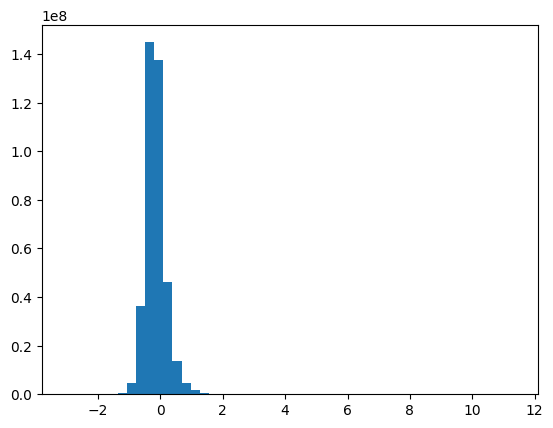

In [ ]:
n_bins = 50
counts, bins = np.histogram(L, bins=n_bins)

plt.bar(bins[:-1], counts, width=np.diff(bins))
plt.show()

In [ ]:
max(L)

11.5195265

In [22]:
k = 20
num_iter = 15

centroid = np.zeros((k, embeddings.shape[1]))

idx = np.random.choice(range(len(embeddings)), k, replace=False)

for i in range(k):
    centroid[i] = embeddings[idx[i]]

centroid.shape

(20, 100)

In [23]:
def euclidean_dist(v1, v2):
    return np.sqrt(np.sum(np.square(v1 - v2), 1))

In [24]:
for _ in range(num_iter):
    print(_)
    centroid_new = np.zeros(centroid.shape)
    count = np.zeros(centroid.shape[0])

    for i in range(len(embeddings)):
        min_dist = 1e18
        min_id = 0
        if i % 10000 == 0:
            print(i)
        dist = euclidean_dist(embeddings[i], centroid)
        min_id = np.argmin(dist)

        centroid_new[min_id] += embeddings[i]
        count[min_id] += 1

    for i in range(k):
        if count[i] == 0:
            continue
        centroid[i] = centroid_new[i] / count[i]


0
0
10000
1
0
10000
2
0
10000
3
0
10000
4
0
10000
5
0
10000
6
0
10000
7
0
10000
8
0
10000
9
0
10000
10
0
10000
11
0
10000
12
0
10000
13
0
10000
14
0
10000


In [25]:
import json

with open("/content/node_id.json", "r") as f:
    node_to_id = json.load(f)

id_to_node = {node_to_id[node]: node for node in node_to_id}


In [ ]:
curr_communities = {i:set() for i in range(k)}

for i in range(len(embeddings)):

    dist = euclidean_dist(embeddings[i], centroid)
    min_id = np.argmin(dist)

    curr_communities[min_id].add(int(id_to_node[i]))

In [ ]:
len(max(curr_communities.values(), key=len))

2072

In [ ]:
len(curr_communities)

20

In [ ]:
modularity(graph, curr_communities)

0.5971133333333333

In [ ]:
L = [0 for _ in range(node_embeddings.shape[0])]
for com in curr_communities:
    for node in curr_communities[com]:
        L[node] = com
            # print(node_to_id[str(node)], com)

import io

out_m = io.open("colours_3.tsv", "w", encoding="utf-8")

for i in range(len(L)):
    out_m.write(str(L[i]) + "\n")
out_m.close()